In [114]:
import numpy as np
import gvar  as gv
import matplotlib.pyplot as plt
import pyerrors as pr

In [4]:
from b2heavy.TwoPointFunctions.types2pts import CorrelatorIO, Correlator
from b2heavy.TwoPointFunctions.fitter    import CorrFitter

In [168]:
ens = 'Coarse-1'
mes = 'Dsst'
mom = '000'
binsize = 11

data_dir = '/Users/pietro/code/data_analysis/BtoD/Alex/'

In [177]:
io     = CorrelatorIO(ens,mes,mom,PathToDataDir=data_dir)
corr   = Correlator(io,jkBin=11,CrossSmearing=True)
fitter = CorrFitter(corr,smearing=['d-d','1S-1S','d-1S'])

In [185]:
trange = (10,19)
Nstates = 2
(X,m_eff,a_eff), MEFF, AEFF, Mpr, Apr = corr.EffectiveCoeff(trange,smearing=['d-d','1S-1S','d-1S'])
priors = fitter.set_priors_phys(Nstates,Meff=MEFF, Aeff=AEFF)


fitter.fit(Nstates,trange,priors=priors)
f = fitter.fits[Nstates,trange]

Fit for (2, (10, 19)) has already been performed. Returning...


In [186]:
print(f)

Least Square Fit:
  chi2/dof [dof] = 0.6 [30]    Q = 0.96    logGBF = 651.57

Parameters:
            E 0   1.14020 (30)      [ 1.14016 (35) ]  
              1     -1.65 (11)      [   -1.66 (57) ]  
              2     -0.67 (17)      [   -1.1 (1.0) ]  
              3     -1.17 (67)      [   -1.1 (1.0) ]  
   Z_1S_Unpol 0    0.5448 (23)      [   0.538 (13) ]  
              1     -0.22 (13)      [   -1.2 (1.2) ]  
              2      0.98 (57)      [    0.5 (1.5) ]  
              3      0.3 (1.4)      [    0.5 (1.5) ]  
 Z_d-1S_Unpol 0      0.61 (19)      [    0.5 (1.7) ]  
              1      0.39 (28)      [    0.5 (1.7) ]  
    Z_d_Unpol 0   -1.7711 (27)      [ -1.7649 (74) ]  
              1     -2.44 (18)      [   -3.0 (1.5) ]  
              2      0.37 (15)      [    0.5 (1.5) ]  
              3      0.23 (20)      [    0.5 (1.5) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 26/0.0)
  fitter = scipy_least_squares    method = trf



# Try use `pyerrors`

In [189]:
corr   = Correlator(io,jkBin=0,CrossSmearing=True)

In [196]:
sm,pol = 'd-d','Unpol'

In [197]:
aux = [pr.Obs([corr.data.loc[sm,pol,:,t].to_numpy()],[ens]) for t in corr.data.timeslice]
Cobs = pr.Corr(aux)

In [198]:
Cobs.gamma_method()

In [200]:
from b2heavy.TwoPointFunctions.utils import NplusN2ptModel
model = NplusN2ptModel(2,fitter.Nt,sm,pol)

In [210]:
X = corr.data.timeslice.to_numpy()
pars = gv.mean(f.p)
model(X,pars)

array([1.02325681e-01, 4.76839766e-02, 5.39745789e-03, 2.43269585e-03,
       3.74559683e-04, 1.56250381e-04, 3.23711864e-05, 1.24073482e-05,
       3.13216617e-06, 1.12632592e-06, 3.16477505e-07, 1.09184691e-07,
       3.24100153e-08, 1.08928104e-08, 3.32884326e-09, 1.10025780e-09,
       3.41825294e-10, 1.11756106e-10, 3.50671956e-11, 1.13823148e-11,
       3.59414301e-12, 1.16097519e-12, 3.68106417e-13, 1.18517759e-13,
       3.76809087e-14, 1.21051949e-14, 3.85574326e-15, 1.23683485e-15,
       3.94484113e-16, 1.26532640e-16, 4.07659936e-17, 1.42398265e-17])

# Damp oscillating states

NameError: name 'dataJk' is not defined

In [29]:
(X,meff,aeff), MEFF,AEFF, m_pr, apr = corr.EffectiveCoeff(trange=(10,20))

/Users/pietro/opt/anaconda3/envs/stat/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [58]:
tExpFac = np.exp(MEFF.mean * corr.data.timeslice.values)

In [105]:
smr,pol = fitter.keys[0]
aux     = [corr.data.loc[smr,pol,jk,:].to_numpy()/tExpFac for jk in corr.data.jkbin]
Cdamp   = 0.25*tExpFac*(aux + 2*np.roll(aux,-1,axis=1) + np.roll(aux,-2,axis=1))
Y       = gv.gvar(
    Cdamp.mean(axis=0),
    np.cov(Cdamp,rowvar=False) * (len(corr.data.jkbin)-1)
)
Yeff = np.log(Y/np.roll(Y,-1))/2 
# meff[k] = np.arccosh(((np.roll(c,-1) + np.roll(c,1))/c/2))/2


C = corr.format()[1][smr,pol]


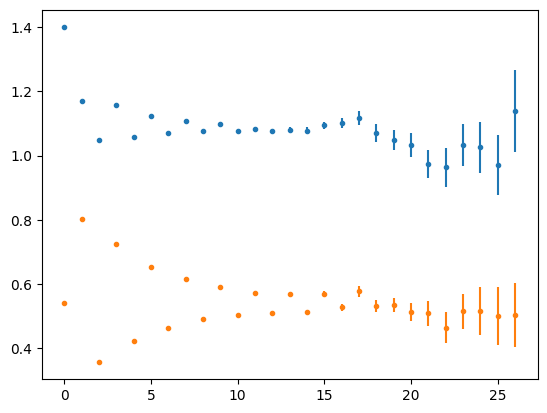

In [106]:
k = (smr,pol)
plt.errorbar(corr.data.timeslice[:27],gv.mean(meff[k])[:27],yerr=gv.sdev(meff[k])[:27],fmt='.')
plt.errorbar(corr.data.timeslice[:27],gv.mean(Yeff)[:27],   yerr=gv.sdev(Yeff)[:27]   ,fmt='.')
plt.savefig('/Users/pietro/Desktop/ciao.pdf')

In [103]:
dataOut = 0.25*tExpFac*(
    dataJk/tExpFac + \
         2*np.roll(dataJk, -1, axis=1)/np.roll(tExpFac, -1, axis=1) \
         + np.roll(dataJk, -2, axis=1)/np.roll(tExpFac, -2, axis=1)
)


AxisError: axis 1 is out of bounds for array of dimension 1

# Old

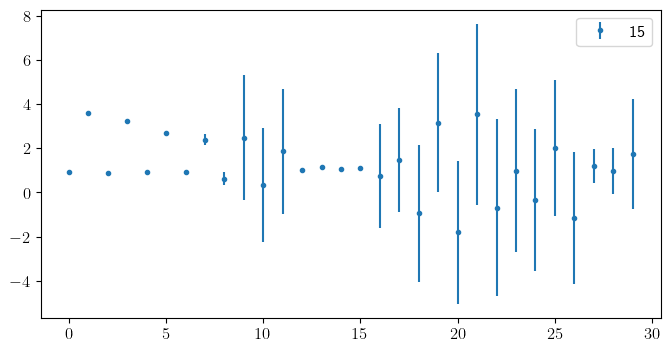

In [64]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.figure(figsize=(8, 4))
ax = plt.subplot(1,1,1)


bestT0 = corr.Nt//2//2-2

for t0 in range(bestT0-2,bestT0+2):
    try:
        y = fitter.GEVP(t0=t0,order=1)['Unpol']
        x = np.arange(0,len(y))
        ax.errorbar(x,gv.mean(y),yerr=gv.sdev(y),fmt='.',label=f'{t0}')

    except:
        continue

ax.legend()